In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
from warnings import filterwarnings
from chainer import serializers
#print(check_output(["dir", "C:/Users/User/Documents/RL_"]).decode("utf8"))
filterwarnings(action='ignore', category=DeprecationWarning, message='`np.bool` is a deprecated alias')
filterwarnings(action='ignore', category=np.VisibleDeprecationWarning)  
# Any results you write to the current directory are saved as output.

D:\Anaconda\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\Anaconda\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
D:\Anaconda\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
D:\Anaconda\lib\site-packages\pkg_resources\__init__.py:123: PkgResourcesDeprecationWarning: 4.0.0-unsupported is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
import time
import copy
import numpy as np
import array as arr
import pandas as pd
import chainer
import chainer.functions as F
import chainer.links as L
import matplotlib.pyplot as plt
from plotly.offline import plot
import datetime
import plotly.graph_objects as go
#from plotly import tools
#from plotly.graph_objs import *
#from plotly.offline import init_notebook_mode, iplot, iplot_mpl

In [3]:
data = pd.read_csv('C:/Users/User/Documents/RL_/Data/Stocks/SPY_WTI.txt')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
print(data.index.min(), data.index.max())
data.head()

2001-01-02 00:00:00 2019-12-30 00:00:00


,Open,High,Low,Close,Adj Close,Volume,WTI_Adj Close
Date,,,,,,,
2001-01-02,1320.280029,1320.280029,1276.050049,1283.270020,1283.270020,1129400000,27.200001
2001-01-03,1283.270020,1347.760010,1274.619995,1347.560059,1347.560059,1880700000,27.950001
2001-01-04,1347.560059,1350.239990,1329.140015,1333.339966,1333.339966,2131000000,28.200001
2001-01-05,1333.339966,1334.770020,1294.949951,1298.349976,1298.349976,1430800000,28.000000
2001-01-08,1298.349976,1298.349976,1276.290039,1295.859985,1295.859985,1115500000,27.350000


In [4]:
start_date = datetime.datetime(2001, 1, 1)
end_date = datetime.datetime(2019, 12, 31)
total_days = (end_date - start_date).days
train_days = int(total_days * 0.5)
test_start_date = start_date + datetime.timedelta(days=train_days)
date_split = test_start_date.date()
train = data[:date_split]
test = data[date_split:]
print("訓練", start_date.date(), "到", test_start_date.date())
print("測試", test_start_date.date(), "到", end_date.date())

訓練 2001-01-01 到 2010-07-02
測試 2010-07-02 到 2019-12-31


In [5]:
def plot_train_test(train, test, date_split):
    # 创建图形
    train_candle = go.Candlestick(x=train.index, open=train['Open'], high=train['High'], low=train['Low'], close=train['Close'], name='Train')
    test_candle = go.Candlestick(x=test.index, open=test['Open'], high=test['High'], low=test['Low'], close=test['Close'], name='Test')
    
    fig = go.Figure(data=[train_candle, test_candle])
    
    # 添加分割线
    fig.add_shape(
        type="line",
        x0=date_split, y0=min(min(train['Low']), min(test['Low'])),
        x1=date_split, y1=max(max(train['High']), max(test['High'])),
        line=dict(color="Black", width=2)
    )
    
    # 添加注释
    fig.add_annotation(
        x=date_split, y=max(max(train['High']), max(test['High'])), ax=0, ay=-30,
        xref='x', yref='y',
        showarrow=True, arrowhead=1,
        text="Start of Test Data"
    )
    
    # 更新布局
    fig.update_layout(title='Train and Test Data Visualization', xaxis_title='Date', yaxis_title='Price')
    
    # 显示图形
    plot(fig)

# 调用函数
plot_train_test(train, test, date_split)

In [6]:
class Environment1:
    
    def __init__(self, data, history_t=90):
        self.data = data
        self.history_t = history_t
        self.reset()
        
    def reset(self):
        self.t = 0
        self.done = False
        self.profits = 10000 #初始資金
        self.count = []
        self.positions = []
        self.position_value = 0
        self.brok_rate=0.0009
        self.max_trade_percent = 0.8
        self.tbrokerage = 0
        self.history = [0 for _ in range(self.history_t)]
        self.Act0=0
        self.Act1=0
        self.Act2=0
        self.RW_p=0
        self.RW_n=0
        self.RW_p_v=0
        self.RW_n_v=0
        return [self.position_value] + self.history # obs
    
    def step(self, act, amount):
        if self.t >= len(self.data) - 1:
            self.done = True
            return [self.position_value] + self.history, 0, self.done
        reward = 0
        #print(act)
        #print(amount)
        # act = 0: stay, 1: buy, 2: sell
        if act == 1:
            if self.profits != 0:
                max_trade_amount = self.profits*self.max_trade_percent
                stock_price = self.data.iloc[self.t, :]['Close']
                count = max_trade_amount / stock_price
                #self.tbrokerage = self.brok_rate*self.data.iloc[self.t, :]['Close']
                buyin = stock_price * count
                self.profits = self.profits - buyin 
                #print('\t'.join(map(str, ['buy',self.data.iloc[self.t, :]['Close'], amount, buyin, self.profits])))
                self.positions.append(stock_price)
                self.count.append(count)
                self.Act1+=1
                #print('\t'.join(map(str, ['buy', amount, buyin, self.profits])))
                
        elif act == 2: # sell
            if len(self.positions) > 0:
                sell_ratio = self.determine_sell_ratio(amount)
                num_positions_to_sell = int(len(self.positions) * sell_ratio)

                for i in range(num_positions_to_sell):
                    sell_price = self.data.iloc[self.t, :]['Close']
                    buy_price = self.positions[i]
                    count = self.count[i]
                    abs_num = (sell_price - buy_price) * count
                    if abs_num > 0: 
                        self.RW_p += 1 
                        self.RW_p_v += abs_num
                    else: 
                        self.RW_n += 1
                        self.RW_n_v += abs(abs_num)
                    reward += sell_price * count
                    self.profits += sell_price * count
                self.positions = self.positions[num_positions_to_sell:]
                self.count = self.count[num_positions_to_sell:]
                self.Act2 += 1    
        
        else :
            self.Act0+=1
        
        # set next time
        self.t += 1
        self.position_value = 0
        for p in self.positions:
            self.position_value += (self.data.iloc[self.t, :]['Close'] - p)
        self.history.pop(0)
        self.history.append(self.data.iloc[self.t, :]['Close'] - self.data.iloc[(self.t-1), :]['Close'])
        
        # clipping reward
        if reward > 0:
            reward = 1
        elif reward < 0:
            reward = -1
        
        return [self.position_value] + self.history, reward, self.done # obs, reward, done
    def determine_sell_ratio(self, signal_strength):
        # Example thresholds and ratios
        thresholds = [0.2, 0.5, 0.8]
        ratios = [0.25, 0.5, 0.75]

        for i, threshold in enumerate(thresholds):
            if signal_strength < threshold:
                return ratios[i]
        return ratios[0]  # Sell the largest ratio but not everything if the signal is very strong

In [7]:
env = Environment1(train)
print(env.reset())
for _ in range(3):
    pact = np.random.randint(3)
    amount = 0.333
    print(env.step(pact,amount))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 64.29003899999998], 0, False)
([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 64.29003899999998, -14.220092999999906], 0, False)
([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [8]:
# DQN

def train_dqn(env):

    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, output_size)
            )

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            y = self.fc3(h)
            return y

        def reset(self):
            self.zerograds()

    Q = Q_Network(input_size=env.history_t+1, hidden_size=100, output_size=3)
    Q_ast = copy.deepcopy(Q)
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(Q)

    epoch_num = 50
    step_max = len(env.data)-1
    memory_size = 200
    batch_size = 20
    epsilon = 1.0
    epsilon_decrease = 1e-3
    epsilon_min = 0.1
    start_reduce_epsilon = 200
    train_freq = 10
    update_q_freq = 20
    gamma = 0.97
    show_log_freq = 1
    confidence_threshold_buy = 0.1
    confidence_threshold_sell = 0.8
    memory = []
    total_step = 0
    total_rewards = []
    total_losses = []
    start = time.time()

    print('\t'.join(map(str, ['epoch','profit','          ','buy','sell','hold'])))
    for epoch in range(epoch_num):

        pobs = env.reset()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0
        RandAct = 0
        NRandAct = 0
        while not done and step < step_max:
            #if step==2264 :
            #    env.profits=10000
            #    env.count=0
                
            # select act
            pact = np.random.randint(3)
            amount = 0.25
            if np.random.rand() > epsilon:
                q_values = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
                softmax_q_values = F.softmax(q_values).data
                #if step==0:print('\t'.join(map(str, [pact])))
                #max_confidence = softmax_q_values
                amount = softmax_q_values.ravel()[pact]
                #pact = np.argmax(softmax_q_values)
                pact = np.random.choice(3, p=softmax_q_values.ravel())
                # act = 0: stay, 1: buy, 2: sell
                if pact == 2:
                    if amount < confidence_threshold_sell:  # confidence_threshold 阈值 
                        pact = 0
                if pact == 1:
                    if amount < confidence_threshold_buy:  # confidence_threshold 阈值
                        pact = 0
                #if epoch > 100 : print('\t'.join(map(str, [pact,amount])))
                NRandAct+=1
            else:
                RandAct+=1
                if pact==0: amount = 0.5
            # act
            obs, reward, done = env.step(pact,amount)

            # add memory
            memory.append((pobs, pact, reward, obs, done))
            if len(memory) > memory_size:
                memory.pop(0)

            # train or update q
            if len(memory) == memory_size:
                if total_step % train_freq == 0:
                    shuffled_memory = np.random.permutation(memory)
                    memory_idx = range(len(shuffled_memory))
                    for i in memory_idx[::batch_size]:
                        batch = np.array(shuffled_memory[i:i+batch_size])
                        b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                        b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                        b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                        q = Q(b_pobs)
                        maxq = np.max(Q_ast(b_obs).data, axis=1)
                        target = copy.deepcopy(q.data)
                        for j in range(batch_size):
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                        Q.reset()
                        loss = F.mean_squared_error(q, target)
                        total_loss += loss.data
                        loss.backward()
                        optimizer.update()

                if total_step % update_q_freq == 0:
                    Q_ast = copy.deepcopy(Q)

            # epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            #log_profits = 0
            log_profits = env.profits
            if len(env.count) != 0:
                for i in range(0,len(env.positions)):
                    log_profits += env.count[i]*env.data.iloc[env.t, :]['Close']
            else :
                log_profits = env.profits
            elapsed_time = time.time()-start
            
            print('\t'.join(map(str, [epoch+1,log_profits,env.Act1,env.Act2,env.Act0])))
            print('\t'.join(map(str, [epoch+1,env.RW_p,env.RW_n,env.RW_p_v,env.RW_n_v])))
            start = time.time()
    chainer.serializers.save_npz('50_2001_WTI_dqn_model.npz', Q)        
    return Q, total_losses, total_rewards
    

In [9]:
Q, total_losses, total_rewards = train_dqn(Environment1(train))

epoch	profit	          	buy	sell	hold
1	6360.978428502108	462	304	1621
1	246	208	10561.030524156105	14199.99172998771
2	7907.7225536567075	397	168	1823
2	203	180	10095.174898890888	11135.734089198062
3	6311.21655087191	363	160	1865
3	200	158	7831.828536134348	10503.252956674893
4	6792.30120045786	306	164	1918
4	148	152	8037.003431953959	10974.713558940075
5	8159.68396329726	387	182	1819
5	203	166	10253.542299718083	11528.441972761591
6	7256.071650746998	502	192	1694
6	241	247	11092.037968128316	12949.192333344678
7	9705.153800987053	539	159	1690
7	320	216	11367.59414949281	10862.49824818241
8	10388.658828168342	553	142	1693
8	307	231	11837.373204828711	11037.752349249871
9	9168.905936157276	616	161	1611
9	350	247	11608.25480886214	11897.736320601163
10	7887.1516661053365	686	101	1601
10	399	273	13303.536681667143	14003.016483292959
11	7853.267820682896	598	137	1653
11	337	245	11863.987401009366	12991.609709403783
12	7767.075814699636	646	121	1621
12	378	231	10417.499478348844	11429.363

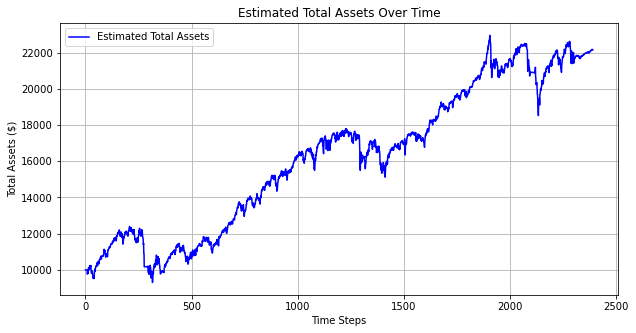

Final profits: 22148.508441149264


In [10]:
import matplotlib.pyplot as plt

def test_dqn(test_env, Q, confidence_threshold_buy=0.1, confidence_threshold_sell=0.8):
    # 重置环境
    pobs = test_env.reset()
    test_env.profits = 10000  # 重置初始资金
    test_acts = []
    test_rewards = []
    estimated_total_assets = [test_env.profits]  # 记录每步的总资产，初始资金为起始值

    while not test_env.done:
        # 使用DQN产生行动的概率分布
        q_values = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
        softmax_q_values = F.softmax(q_values).data
        pact = np.random.choice(3, p=softmax_q_values.ravel())
        
        # 根据设定的阈值判断是否执行买入或卖出
        amount = softmax_q_values.ravel()[pact]
        if pact == 2 and amount < confidence_threshold_sell:
            pact = 0
        elif pact == 1 and amount < confidence_threshold_buy:
            pact = 0
        
        # 执行行动
        obs, reward, done = test_env.step(pact, amount)
        test_acts.append(pact)
        test_rewards.append(reward)
        pobs = obs

        # 估算总资产
        stock_value = sum(c * test_env.data.iloc[test_env.t]['Close'] for c in test_env.count)
        total_assets = test_env.profits + stock_value
        estimated_total_assets.append(total_assets)

    # 绘制估算总资产的折线图
    plt.figure(figsize=(10, 5))
    plt.plot(estimated_total_assets, label='Estimated Total Assets', color='blue')
    plt.title('Estimated Total Assets Over Time')
    plt.xlabel('Time Steps')
    plt.ylabel('Total Assets ($)')
    plt.legend()
    plt.grid(True)
    plt.show()

    final_profits = total_assets
    return test_acts, test_rewards, final_profits
def load_and_test_dqn(test_env):

    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, output_size)
            )

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            y = self.fc3(h)
            return y

        def reset(self):
            self.zerograds()
    Q_loaded = Q_Network(input_size=test_env.history_t+1, hidden_size=100, output_size=3)
    chainer.serializers.load_npz('50_2001_WTI_dqn_model.npz', Q_loaded)
    
    # 现在使用加载的模型来进行测试
    test_acts, test_rewards, test_profits = test_dqn(test_env, Q_loaded)
    #print("Test actions:", test_acts)
    #print("Test rewards:", test_rewards)
    print("Final profits:", test_profits)
# 调用函数进行测试
test_data = test  # 确保已正确设置测试数据
test_env = Environment1(data=test_data, history_t=90)
load_and_test_dqn(test_env)

In [11]:
def plot_loss_reward(total_losses, total_rewards):

    figure = tools.make_subplots(rows=1, cols=2, subplot_titles=('loss', 'reward'), print_grid=False)
    figure.append_trace(Scatter(y=total_losses, mode='lines', line=dict(color='skyblue')), 1, 1)
    figure.append_trace(Scatter(y=total_rewards, mode='lines', line=dict(color='orange')), 1, 2)
    figure['layout']['xaxis1'].update(title='epoch')
    figure['layout']['xaxis2'].update(title='epoch')
    figure['layout'].update(height=400, width=900, showlegend=False)
    iplot(figure)
    

In [12]:
# Double DQN

def train_ddqn(env):

    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, output_size)
            )

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            y = self.fc3(h)
            return y

        def reset(self):
            self.zerograds()    
    Q = Q_Network(input_size=env.history_t+1, hidden_size=100, output_size=3)
    Q_ast = copy.deepcopy(Q)
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(Q)

    epoch_num = 50
    step_max = len(env.data)-1
    memory_size = 200
    batch_size = 50
    epsilon = 1.0
    epsilon_decrease = 1e-3
    epsilon_min = 0.1
    start_reduce_epsilon = 200
    train_freq = 10
    update_q_freq = 20
    confidence_threshold_buy = 0.1
    confidence_threshold_sell = 0.8
    gamma = 0.97
    show_log_freq = 1

    memory = []
    total_step = 0
    total_rewards = []
    total_losses = []

    start = time.time()
    print('\t'.join(map(str, ['epoch','profit','          ','buy','sell','hold'])))
    for epoch in range(epoch_num):

        pobs = env.reset()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0
        RandAct = 0
        NRandAct = 0
        while not done and step < step_max:
            #if step==2264 :
            #    env.profits=10000
            #    env.count=0
            pact = np.random.randint(3)
            amount = 0.25
            if np.random.rand() > epsilon:
                q_values = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
                softmax_q_values = F.softmax(q_values).data
                #if step==0:print('\t'.join(map(str, [pact])))
                #max_confidence = softmax_q_values
                amount = softmax_q_values.ravel()[pact]
                pact = np.random.choice(3, p=softmax_q_values.ravel())
                # act = 0: stay, 1: buy, 2: sell
                if pact == 2:
                    if amount < confidence_threshold_sell:  # confidence_threshold 阈值 
                        pact = 0
                if pact == 1:
                    if amount < confidence_threshold_buy:  # confidence_threshold 阈值
                        pact = 0
                #if epoch > 100 : print('\t'.join(map(str, [pact,amount])))
                NRandAct+=1
            else:
                RandAct+=1
                if pact==0: amount = 0.5
            # act
            obs, reward, done = env.step(pact,amount)

            # add memory
            memory.append((pobs, pact, reward, obs, done))
            if len(memory) > memory_size:
                memory.pop(0)

            # train or update q
            if len(memory) == memory_size:
                if total_step % train_freq == 0:
                    shuffled_memory = np.random.permutation(memory)
                    memory_idx = range(len(shuffled_memory))
                    for i in memory_idx[::batch_size]:
                        batch = np.array(shuffled_memory[i:i+batch_size])
                        b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                        b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                        b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                        q = Q(b_pobs)
                        """ <<< DQN -> Double DQN
                        maxq = np.max(Q_ast(b_obs).data, axis=1)
                        === """
                        indices = np.argmax(q.data, axis=1)
                        maxqs = Q_ast(b_obs).data
                        """ >>> """
                        target = copy.deepcopy(q.data)
                        for j in range(batch_size):
                            """ <<< DQN -> Double DQN
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                            === """
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxqs[j, indices[j]]*(not b_done[j])
                            """ >>> """
                        Q.reset()
                        loss = F.mean_squared_error(q, target)
                        total_loss += loss.data
                        loss.backward()
                        optimizer.update()

                if total_step % update_q_freq == 0:
                    Q_ast = copy.deepcopy(Q)

            # epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            log_profits = env.profits
            if len(env.count) != 0:
                for i in range(0,len(env.positions)):
                    log_profits += env.count[i]*env.data.iloc[env.t, :]['Close']
            else :
                log_profits = env.profits
            elapsed_time = time.time()-start
            print('\t'.join(map(str, [epoch+1,log_profits,env.Act1,env.Act2,env.Act0])))
            print('\t'.join(map(str, [epoch+1,env.RW_p,env.RW_n,env.RW_p_v,env.RW_n_v])))
            start = time.time()
    save_models(Q, Q_ast)       
    return Q, total_losses, total_rewards
def save_models(Q, Q_ast, behavior_filename='50_2001_WTI_ddqn_behavior_model.npz', target_filename='50_2001_WTI_ddqn_target_model.npz'):
    serializers.save_npz(behavior_filename, Q)
    serializers.save_npz(target_filename, Q_ast)

In [13]:
Q, total_losses, total_rewards = train_ddqn(Environment1(train))

epoch	profit	          	buy	sell	hold
1	9731.60220798776	545	387	1456
1	287	240	17566.764374296694	17797.00616755441
2	10308.931762140468	521	196	1671
2	307	212	16890.335608674406	16425.96237924251
3	8548.055303346759	564	129	1695
3	343	203	11779.611889976388	12148.635560059834
4	8768.72855686981	636	71	1681
4	351	264	9917.634690591318	9791.90579064086
5	10518.65867584918	816	80	1490
5	446	325	14278.245330681211	13115.87869053419
6	7715.364559893224	709	90	1589
6	359	326	10482.039834614525	11625.4657104993
7	9619.086868539262	671	96	1621
7	393	247	12202.652702027024	11577.89426316339
8	8745.495718949996	652	81	1655
8	363	270	12198.920915505141	13004.828555418631
9	8779.067926698457	690	73	1625
9	398	278	10323.535673832015	10681.459246132325
10	9348.139320030603	600	93	1693
10	364	221	10574.7908438043	10774.006867887776
11	7209.5483239201785	647	102	1639
11	351	272	8305.756275769781	10510.813001540939
12	8131.342502994041	668	97	1623
12	364	286	10672.26411891126	12260.133243780087
13	78

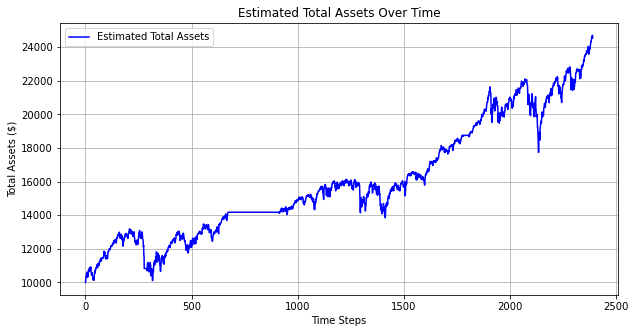

Final profits: 24558.095709655423


In [14]:
import matplotlib.pyplot as plt

def test_ddqn(test_env, Q, Q_ast, buy_threshold=0.1, sell_threshold=0.8):
    # 重置环境并获取初始状态
    pobs = test_env.reset()
    test_env.profits = 10000  # 如果需要的话，重置初始资金
    test_acts = []
    test_rewards = []
    test_profits = [test_env.profits]  # 记录每一步后的利润
    estimated_total_assets = [test_env.profits]  # 包括估算的持股价值的总资产列表

    while not test_env.done:
        # 使用训练好的DDQN模型选择行动
        q_values = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
        softmax_q_values = F.softmax(q_values).data.ravel()
        action = np.random.choice(3, p=softmax_q_values)
        action_prob = softmax_q_values[action]
        amount = action_prob

        # 根据阈值判断是否执行买入或卖出
        if action == 1 and action_prob < buy_threshold:
            action = 0
            amount = 0
        elif action == 2 and action_prob < sell_threshold:
            action = 0
            amount = 0

        obs, reward, done = test_env.step(action, amount)
        if done:
            break
        test_acts.append(action)
        test_rewards.append(reward)
        pobs = obs
        test_profits.append(test_env.profits)

        # 估算总资产（不实际卖出股票）
        stock_value = sum(c * test_env.data.iloc[test_env.t]['Close'] for c in test_env.count)
        total_assets = test_env.profits + stock_value
        estimated_total_assets.append(total_assets)
    # 测试最后一天，将所有持股转换为现金
    final_stock_value = sum(c * test_env.data.iloc[-1]['Close'] for c in test_env.count)
    final_profits = test_env.profits + final_stock_value
    estimated_total_assets[-1] = final_profits  # 更新最后的总资产估计值
    #print("Test actions:", test_acts)
    #print("Test rewards:", test_rewards)
    

    # 绘制总资产变化的折线图
    plt.figure(figsize=(10, 5))
    plt.plot(estimated_total_assets, label='Estimated Total Assets', color='blue')
    plt.title('Estimated Total Assets Over Time')
    plt.xlabel('Time Steps')
    plt.ylabel('Total Assets ($)')
    plt.legend()
    plt.grid(True)
    plt.show()
    print("Final profits:", final_profits)
    return test_acts, test_rewards, final_profits

class Q_Network(chainer.Chain):

    def __init__(self, input_size, hidden_size, output_size):
        super(Q_Network, self).__init__(
            fc1 = L.Linear(input_size, hidden_size),
            fc2 = L.Linear(hidden_size, hidden_size),
            fc3 = L.Linear(hidden_size, output_size)
        )

    def __call__(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        y = self.fc3(h)
        return y

    def reset(self):
        self.zerograds() 
# 确保以下是您实际调用测试函数的部分
test_data = test  # 确保已正确设置测试数据
test_env = Environment1(data=test_data, history_t=90)

Q_loaded = Q_Network(input_size=test_env.history_t+1, hidden_size=100, output_size=3)
chainer.serializers.load_npz('50_2001_WTI_ddqn_behavior_model.npz', Q_loaded)

Q_ast_loaded = Q_Network(input_size=test_env.history_t+1, hidden_size=100, output_size=3)
chainer.serializers.load_npz('50_2001_WTI_ddqn_target_model.npz', Q_ast_loaded)

# 运行测试
test_acts, test_rewards, test_profits = test_ddqn(test_env, Q_loaded, Q_ast_loaded)

In [15]:
# Dueling Double DQN

def train_dddqn(env):

    """ <<< Double DQN -> Dueling Double DQN
    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, output_size)
            )

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            y = self.fc3(h)
            return y

        def reset(self):
            self.zerograds()
    === """
    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, hidden_size//2),
                fc4 = L.Linear(hidden_size, hidden_size//2),
                state_value = L.Linear(hidden_size//2, 1),
                advantage_value = L.Linear(hidden_size//2, output_size)
            )
            self.input_size = input_size
            self.hidden_size = hidden_size
            self.output_size = output_size

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            hs = F.relu(self.fc3(h))
            ha = F.relu(self.fc4(h))
            state_value = self.state_value(hs)
            advantage_value = self.advantage_value(ha)
            advantage_mean = (F.sum(advantage_value, axis=1)/float(self.output_size)).reshape(-1, 1)
            q_value = F.concat([state_value for _ in range(self.output_size)], axis=1) + (advantage_value - F.concat([advantage_mean for _ in range(self.output_size)], axis=1))
            return q_value

        def reset(self):
            self.zerograds()
    """ >>> """

    Q = Q_Network(input_size=env.history_t+1, hidden_size=100, output_size=3)
    Q_ast = copy.deepcopy(Q)
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(Q)

    epoch_num = 50
    step_max = len(env.data)-1
    memory_size = 200
    batch_size = 50
    epsilon = 1.0
    epsilon_decrease = 1e-3
    epsilon_min = 0.1
    start_reduce_epsilon = 200
    train_freq = 10
    update_q_freq = 20
    gamma = 0.97
    confidence_threshold_buy = 0.1
    confidence_threshold_sell = 0.8
    show_log_freq = 1

    memory = []
    total_step = 0
    total_rewards = []
    total_losses = []

    start = time.time()
    print('\t'.join(map(str, ['epoch','profit','          ','buy','sell','hold'])))
    for epoch in range(epoch_num):

        pobs = env.reset()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0
        RandAct = 0
        NRandAct = 0
        while not done and step < step_max:
            #if step==2264 :
            #    env.profits=10000
            #    env.count=0
            # select act
            pact = np.random.randint(3)
            amount = 0.25
            if np.random.rand() > epsilon:
                q_values = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
                softmax_q_values = F.softmax(q_values).data
                #if step==0:print('\t'.join(map(str, [pact])))
                #max_confidence = softmax_q_values
                amount = softmax_q_values.ravel()[pact]
                pact = np.random.choice(3, p=softmax_q_values.ravel())
                # act = 0: stay, 1: buy, 2: sell
                if pact == 2:
                    if amount < confidence_threshold_sell:  # confidence_threshold 阈值 
                        pact = 0
                if pact == 1:
                    if amount < confidence_threshold_buy:  # confidence_threshold 阈值
                        pact = 0
                #if epoch > 100 : print('\t'.join(map(str, [pact,amount])))
                NRandAct+=1
            else:
                RandAct+=1
                if pact==0: amount = 0.5
            # act
            obs, reward, done = env.step(pact,amount)

            # add memory
            memory.append((pobs, pact, reward, obs, done))
            if len(memory) > memory_size:
                memory.pop(0)

            # train or update q
            if len(memory) == memory_size:
                if total_step % train_freq == 0:
                    shuffled_memory = np.random.permutation(memory)
                    memory_idx = range(len(shuffled_memory))
                    for i in memory_idx[::batch_size]:
                        batch = np.array(shuffled_memory[i:i+batch_size])
                        b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                        b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                        b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                        q = Q(b_pobs)
                        """ <<< DQN -> Double DQN
                        maxq = np.max(Q_ast(b_obs).data, axis=1)
                        === """
                        indices = np.argmax(q.data, axis=1)
                        maxqs = Q_ast(b_obs).data
                        """ >>> """
                        target = copy.deepcopy(q.data)
                        for j in range(batch_size):
                            """ <<< DQN -> Double DQN
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                            === """
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxqs[j, indices[j]]*(not b_done[j])
                            """ >>> """
                        Q.reset()
                        loss = F.mean_squared_error(q, target)
                        total_loss += loss.data
                        loss.backward()
                        optimizer.update()

                if total_step % update_q_freq == 0:
                    Q_ast = copy.deepcopy(Q)

            # epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            log_profits = env.profits
            if len(env.count) != 0:
                for i in range(0,len(env.positions)):
                    log_profits += env.count[i]*env.data.iloc[env.t, :]['Close']
            else :
                log_profits = env.profits
            elapsed_time = time.time()-start
            print('\t'.join(map(str, [epoch+1,log_profits,env.Act1,env.Act2,env.Act0])))
            print('\t'.join(map(str, [epoch+1,env.RW_p,env.RW_n,env.RW_p_v,env.RW_n_v])))
            start = time.time()
    chainer.serializers.save_npz('50_2001_WTI_dueling_ddqn_model.npz', Q)
    chainer.serializers.save_npz('50_2001_WTI_dueling_ddqn_target_model.npz', Q_ast)        
    return Q, total_losses, total_rewards

In [16]:
Q, total_losses, total_rewards = train_dddqn(Environment1(train))

epoch	profit	          	buy	sell	hold
1	7439.992294675118	660	318	1410
1	396	253	13249.0030774951	15400.94985631801
2	7606.691478336194	657	101	1630
2	411	242	8852.31546221965	10761.082916400668
3	7735.837845563216	786	89	1513
3	372	400	9397.15483515828	11116.950152829488
4	8418.096459402235	676	102	1610
4	374	289	10919.161969482297	11898.978618675465
5	7270.314079314406	711	83	1594
5	390	287	8237.424586064548	10248.894276285442
6	10650.78148152119	671	95	1622
6	336	315	13073.428439513	10501.912564582928
7	7286.428113315772	710	63	1615
7	439	229	7996.17987169236	9399.849635971852
8	6563.321535063665	761	75	1552
8	445	305	9360.07418831025	12772.164242183047
9	7120.939250286487	803	68	1517
9	466	328	9479.920089227622	12051.307328991608
10	7011.58955173173	740	80	1568
10	415	305	10618.295398893453	12801.826361998861
11	6617.7510797473515	754	80	1554
11	369	361	8551.576411333199	11057.714910731576
12	9195.822841398998	803	67	1518
12	434	332	10384.297733446529	10562.416693076922
13	7684.921

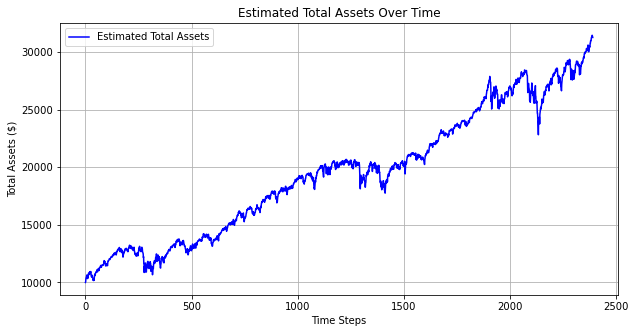

Final profits: 31263.636099768173


In [17]:
import plotly.graph_objects as go
import numpy as np

def test_dueling_ddqn(test_env, Q, buy_threshold=0.1, sell_threshold=0.8):
    pobs = test_env.reset()
    test_env.profits = 10000  # 重置初始资金
    test_acts = []
    test_rewards = []
    test_profits = []
    estimated_total_assets = [test_env.profits]  # 包括估算的持股价值的总资产列表
    while not test_env.done:
        q_values = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
        softmax_q_values = F.softmax(q_values).data.ravel()
        action = np.random.choice(3, p=softmax_q_values)  # 随机选择行动，基于概率分布
        action_prob = softmax_q_values[action]

        # 设置交易的金额或数量，这里假设简单地将概率值转换为金额或比例
        amount = action_prob

        # 考虑不同行动的阈值
        if action == 1 and action_prob < buy_threshold:  # 买入行动的阈值判断
            action = 0  # 如果买入概率低于买入阈值，则不买入
            amount = 0
        elif action == 2 and action_prob < sell_threshold:  # 卖出行动的阈值判断
            action = 0  # 如果卖出概率低于卖出阈值，则不卖出
            amount = 0

        obs, reward, done = test_env.step(action, amount)
        test_acts.append(action)
        test_rewards.append(reward)
        pobs = obs

        # 估计每日的现有资金（假设所有持仓都卖出但不真正执行）
        simulated_profits = test_env.profits + sum(pos * test_env.data.iloc[test_env.t, :]['Close'] for pos in test_env.count)
        test_profits.append(simulated_profits)
        estimated_total_assets.append(simulated_profits)
    # 绘制折线图显示每日利润变化
    plt.figure(figsize=(10, 5))
    plt.plot(estimated_total_assets, label='Estimated Total Assets', color='blue')
    plt.title('Estimated Total Assets Over Time')
    plt.xlabel('Time Steps')
    plt.ylabel('Total Assets ($)')
    plt.legend()
    plt.grid(True)
    plt.show()
    test_env.profits = simulated_profits
    return test_acts, test_rewards, test_env.profits

def load_and_test_dueling_ddqn(test_env):
    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, hidden_size//2),
                fc4 = L.Linear(hidden_size, hidden_size//2),
                state_value = L.Linear(hidden_size//2, 1),
                advantage_value = L.Linear(hidden_size//2, output_size)
            )
            self.input_size = input_size
            self.hidden_size = hidden_size
            self.output_size = output_size

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            hs = F.relu(self.fc3(h))
            ha = F.relu(self.fc4(h))
            state_value = self.state_value(hs)
            advantage_value = self.advantage_value(ha)
            advantage_mean = (F.sum(advantage_value, axis=1)/float(self.output_size)).reshape(-1, 1)
            q_value = F.concat([state_value for _ in range(self.output_size)], axis=1) + (advantage_value - F.concat([advantage_mean for _ in range(self.output_size)], axis=1))
            return q_value

        def reset(self):
            self.zerograds()
    Q_loaded = Q_Network(input_size=test_env.history_t+1, hidden_size=100, output_size=3)
    chainer.serializers.load_npz('50_2001_WTI_dueling_ddqn_model.npz', Q_loaded)
    test_acts, test_rewards, test_profits = test_dueling_ddqn(test_env, Q_loaded, buy_threshold=0.1, sell_threshold=0.6)
    #print("Test actions:", test_acts)
    #print("Test rewards:", test_rewards)
    print("Final profits:", test_profits)

test_data = test  # 这里应该是您加载或定义测试数据集的代码
test_env = Environment1(data=test_data, history_t=90)
load_and_test_dueling_ddqn(test_env)